In [3]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Flatten
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import keras_tuner as kt
from sklearn.metrics import roc_auc_score, confusion_matrix
import seaborn as sns

In [4]:
conv_base = VGG16(
    weights='imagenet',
    include_top = False,
    input_shape=(224,224,3)
)

I0000 00:00:1752161336.060972      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1752161336.061721      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=1000,
    decay_rate=0.9
)
optimizer = keras.optimizers.RMSprop(learning_rate=lr_schedule)

In [6]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,  # Reduce learning rate by a factor of 0.2
    patience=3,  # Wait 3 epochs before reducing
    min_lr=1e-6  # Minimum learning rate
)

In [7]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define data augmentation as a keras Sequential model
data_augmentation = keras.Sequential([
    # layers.RandomFlip("horizontal"),
    # layers.RandomRotation(0.2),  # Increase rotation
    # layers.RandomZoom(0.3),
    # layers.RandomTranslation(0.2, 0.2),
    # layers.RandomContrast(0.2),  # Add contrast adjustment
    # layers.RandomBrightness(0.2)# Add brightness adjustment
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])
# Load datasets from your directories (with your exact paths)
train_ds = keras.utils.image_dataset_from_directory(
    directory='/kaggle/input/content/Fold1/Fold1/Fold1/Train',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(224, 224)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory='/kaggle/input/content/Fold1/Fold1/Fold1/Val',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(224, 224)
)

# Function to apply augmentation and normalization to training data
def process_train(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0,1]
    image = data_augmentation(image)            # Apply augmentation
    return image, label

# Function to normalize validation data only
def process_val(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0,1]
    return image, label

# Apply the processing functions
train_ds = train_ds.map(process_train, num_parallel_calls=tf.data.AUTOTUNE)
validation_ds = validation_ds.map(process_val, num_parallel_calls=tf.data.AUTOTUNE)

# Prefetch for performance
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
validation_ds = validation_ds.prefetch(tf.data.AUTOTUNE)

Found 2142 files belonging to 2 classes.
Found 420 files belonging to 2 classes.


In [ ]:
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications.inception_v3 import InceptionV3



# Unfreeze top 20 layers of InceptionV3
for layer in conv_base.layers[-20:]:
    layer.trainable = True

# Freeze all layers initially
# conv_base.trainable = False

def build_model(hp):
    model = Sequential()
    model.add(conv_base)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(
        units=hp.Int('units', min_value=128, max_value=512, step=128),
        activation='relu'
    ))
    # model.add(Dropout(hp.Float('dropout', 0.2, 0.5, step=0.1)))
    model.add(Dropout(.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Float('learning_rate', 1e-5, 1e-3, sampling='log')
        ),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    # executions_per_trial=2,
    directory='tuner_dir_1',
    project_name='vgg16_tuning'
)
tuner.search(train_ds, validation_data=validation_ds, epochs=5)
best_model = tuner.get_best_models(num_models=1)[0]

Trial 9 Complete [00h 03m 18s]
val_accuracy: 0.5642856955528259

Best val_accuracy So Far: 0.7571428418159485
Total elapsed time: 00h 29m 43s

Search: Running Trial #10

Value             |Best Value So Far |Hyperparameter
128               |384               |units
0.00013072        |0.00078837        |learning_rate

Epoch 1/5
67/67 ━━━━━━━━━━━━━━━━━━━━ 49s 604ms/step - accuracy: 0.8082 - loss: 0.3420 - val_accuracy: 0.5833 - val_loss: 1.6063
Epoch 2/5
 2/67 ━━━━━━━━━━━━━━━━━━━━ 32s 506ms/step - accuracy: 0.9297 - loss: 0.1382

In [ ]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint
# Optional: Get the best hyperparameters for reference
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
# Create output directory
output_dir = '/kaggle/working/inceptionv3_models/'
os.makedirs(output_dir, exist_ok=True)
best_model.save(os.path.join(output_dir, 'best_model.keras'))
best_model.save_weights(os.path.join(output_dir, 'best_model_weights.weights.h5'))
print(f"Best units: {best_hps.get('units')}")
# print(f"Best dropout: {best_hps.get('dropout')}")
print(f"Best learning rate: {best_hps.get('learning_rate')}")

# Define callbacks for further training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
checkpoint = ModelCheckpoint('best_finetuned_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')

# Optional: Compute class weights for imbalanced data
from sklearn.utils import class_weight
import numpy as np
y_train = np.concatenate([labels.numpy() for _, labels in train_ds])
class_weights = class_weight.compute_class_weight(
    class_weight='balanced', classes=np.unique(y_train), y=y_train
)
class_weights = dict(enumerate(class_weights))

# Further train the best model
history = best_model.fit(
    train_ds,
    epochs=50,  # Train for more epochs
    validation_data=validation_ds,
    # class_weight=class_weights,  # Apply class weights if needed
    # callbacks=[early_stopping, reduce_lr, checkpoint]
)

# Evaluate the model on test dataset
# loss, accuracy = best_model.evaluate(test_ds)
# print(f"Test Loss: {loss:.4f}")
# print(f"Test Accuracy: {accuracy:.4f}")

In [11]:

# import json
# import pickle

# # Save best hyperparameters
# best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
# with open(os.path.join(output_dir, 'best_hyperparameters.json'), 'w') as f:
#     json.dump(best_hps.values, f, indent=4)

# # Save trials summary
# trials_summary = [
#     {
#         'trial_id': trial.trial_id,
#         'hyperparameters': trial.hyperparameters.values,
#         'score': trial.score,
#         'status': trial.status
#     } for trial in tuner.oracle.trials.values()
# ]
# with open(os.path.join(output_dir, 'trials_summary.json'), 'w') as f:
#     json.dump(trials_summary, f, indent=4)

# # Save training history
# with open(os.path.join(output_dir, 'training_history.pkl'), 'wb') as f:
#     pickle.dump(history.history, f)

# # Save trials history
# best_trials = tuner.oracle.get_best_trials(num_trials=5)
# trials_history = {trial.trial_id: trial.metrics.get_history() for trial in best_trials}
# with open(os.path.join(output_dir, 'trials_history.pkl'), 'wb') as f:
#     pickle.dump(trials_history, f)

# # Create ZIP archive
# shutil.make_archive('/kaggle/working/inceptionv3_models', 'zip', output_dir)
# print("All files saved in", output_dir)
# print("ZIP archive created at /kaggle/working/inceptionv3_models.zip")

TypeError: MetricsTracker.get_history() missing 1 required positional argument: 'name'

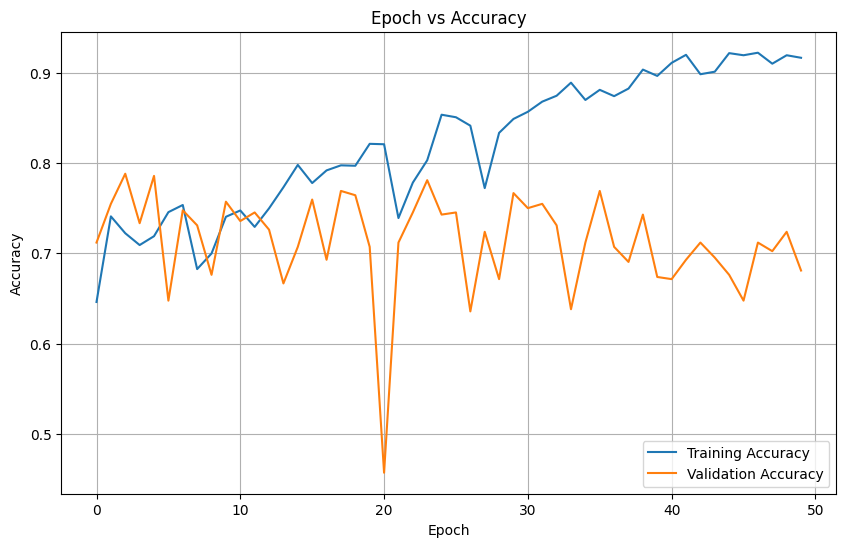

In [13]:
import matplotlib.pyplot as plt
# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Epoch vs Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig('/kaggle/working/inceptionv3_models/accuracy_plot.png')
plt.show()

In [14]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 384)                 │         196,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             385 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,736,197 (170.66 MB)

 Trainable params: 14,912,065 (56.89 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 29,824,132 (113.77 MB)

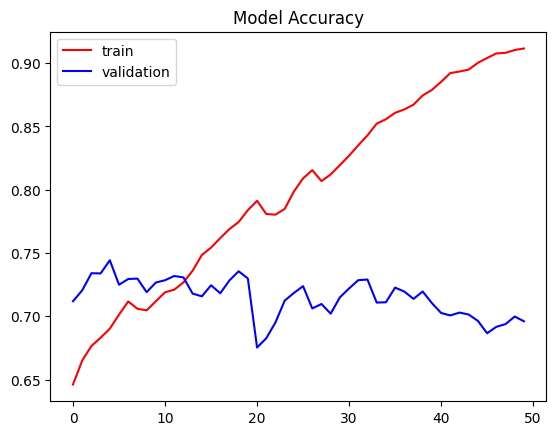

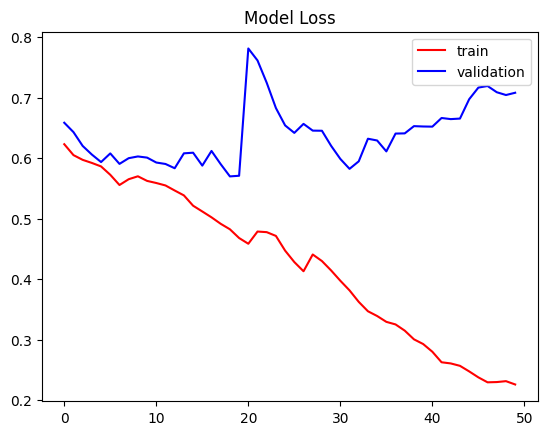

In [15]:
import matplotlib.pyplot as plt
# Plot training curves
def smooth_curve(points, factor=0.8):
    smoothed = []
    for point in points:
        if smoothed:
            smoothed.append(smoothed[-1] * factor + point * (1 - factor))
        else:
            smoothed.append(point)
    return smoothed

plt.plot(smooth_curve(history.history['accuracy']), color='red', label='train')
plt.plot(smooth_curve(history.history['val_accuracy']), color='blue', label='validation')
plt.title('Model Accuracy')
plt.legend()
plt.show()

plt.plot(smooth_curve(history.history['loss']), color='red', label='train')
plt.plot(smooth_curve(history.history['val_loss']), color='blue', label='validation')
plt.title('Model Loss')
plt.legend()
plt.show()

Found 2142 files belonging to 2 classes.
Found 420 files belonging to 2 classes.


In [20]:
# Load the Validation Dataset

from tensorflow.keras.utils import image_dataset_from_directory

test_dir = '/kaggle/input/content/Fold1/Fold1/Fold1/Test'

test_ds = image_dataset_from_directory(
    directory=test_dir,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(224, 224)
)
# Evaluate the model on test dataset
loss, accuracy = best_model.evaluate(test_ds)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Found 45 files belonging to 2 classes.
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 492ms/step - accuracy: 0.4421 - loss: 16.8856
Test Loss: 16.6952
Test Accuracy: 0.4444


In [21]:
# Evaluate on test set
loss, accuracy = best_model.evaluate(test_ds)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.4525 - loss: 16.2875
Test Loss: 16.6952
Test Accuracy: 0.4444


In [26]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, roc_auc_score

# Classification report and AUC
y_true = []
y_pred_probs = []

# Resize images to (224, 224) to match InceptionV3 input requirements
def resize_image(image, label):
    image = tf.image.resize(image, [224, 224])  # Resize to (224, 224)
    return image, label

# Apply resizing to the test dataset
test_ds_resized = test_ds.map(resize_image, num_parallel_calls=tf.data.AUTOTUNE)

# Predict on resized test dataset
for images, labels in test_ds_resized:
    preds = best_model.predict(images).flatten()  # Predict probabilities
    y_true.extend(labels.numpy())  # True labels
    y_pred_probs.extend(preds)     # Predicted probabilities

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)

# Classification report
class_names = test_ds.class_names
print(classification_report(y_true, (y_pred_probs > 0.5).astype(int), target_names=class_names))

# AUC-ROC
auc = roc_auc_score(y_true, y_pred_probs)
print(f"AUC-ROC: {auc:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
              precision    recall  f1-score   support

   Monkeypox       0.44      1.00      0.62        20
      Others       0.00      0.00      0.00        25

    accuracy                           0.44        45
   macro avg       0.22      0.50      0.31        45
weighted avg       0.20      0.44      0.27        45

AUC-ROC: 0.8400


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


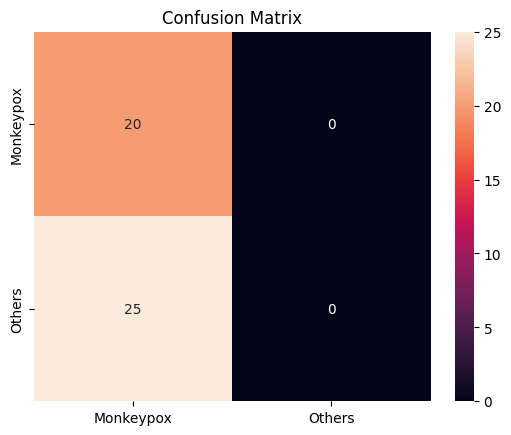

In [27]:
# Confusion matrix
cm = confusion_matrix(y_true, (np.array(y_pred_probs) > 0.5).astype(int))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_true, (np.array(y_pred_probs) > 0.5).astype(int))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

y_true = []
y_pred = []

for images, labels in validation_ds:
    preds = model.predict(images).flatten()
    pred_labels = (preds > 0.5).astype(int)
    y_true.extend(labels.numpy())
    y_pred.extend(pred_labels)
class_name=["monkeypox","others"]
class_names = validation_ds.class_names  # ['monkeypox', 'others']

print(classification_report(y_true, y_pred, target_names=class_names))


In [ ]:
# Load the Validation Dataset

from tensorflow.keras.utils import image_dataset_from_directory

test_dir = '/content/Fold1/Fold1/Fold1/Test'

test_ds = image_dataset_from_directory(
    directory=test_dir,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(224, 224)
)
# Normalize images
def preprocess(image, label):
    image = tf.cast(image / 255.0, tf.float32)
    return image, label

test_ds = test_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


Train class counts:
Others: 1162
Monkeypox: 980
